# CE - 88 Data Science for Smart Cities

**Due date: Monday, October 30th 11:59pm**

## Homework 2

### 1. Least square linear regression (30 points)

You are given the set of data:

{(-2,1),(-1,3),(0,4),(2,3),(4,7)}

**1.1 (5 points)** Find the least square regression line of the set. The regression line must be modeled as $y = \theta_1 x + \theta_2$. Type a list of $\theta_1$ and $\theta_2$ into the answer, i.e., [$\theta_1$, $\theta_2$]

**1.2 (5 points)** Find $R^2$ of the regression line (Your answer needs to be rounded to 2-decimal places).

In [ ]:
# Your analysis and answers here:
import numpy as np
d = [-2, -1, 0, 2, 4]
X = np.vstack([d, np.ones(len(d))]).T
y = np.array([1, 3, 4, 3, 7])
theta = np.linalg.solve(X.T.dot(X), X.T.dot(y))
theta

In [6]:
# Total sum of squares
SS_tot = np.sum(np.square(y-np.mean(y)))

# Sum of squares of residuals
SS_res = np.sum(np.square(y-[theta[0]*x + theta[1] for x in d]))

# R^2
R2 = 1 - SS_res/SS_tot

# Solution 2: using skitlearn
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

reg = linear_model.LinearRegression()
reg.fit(np.array(d).reshape((len(d),1)),y.reshape((len(y),1)))
pred = reg.predict(np.array(d).reshape((len(d),1)))
r2_score(y.reshape((len(y),1)), pred)

0.74362428160919536

Now, you want to predict daily average power loads by given daily average temperature during summer (June - Aug) for the year 2016, with given power loads data in 2014 and 2015, using linear regression. That is, train your linear regressor with the summer data in 2014 and 2015 (Use "DUQ" column for the power load) and predict daily average power loads by daily average temperatures over the 2016 summer.

Use the following function to convert "date" string into datetime object.


In [9]:
from datetime import datetime
def getDatetimeObj(dateStr, fmt):
    """
    Convert string in date format to datatime object
    """
    try:
        t = datetime.strptime(dateStr, fmt)
    except ValueError as v:
        if len(v.args) > 0 and v.args[0].startswith('unconverted data remains: '):
            dateStr = dateStr[:-(len(v.args[0]) - 26)]
            t = datetime.strptime(dateStr, fmt)
        else:
            raise
    return t

# Example:
# table_load = ds.Table.read_table("2014.csv")
# table_load["DAY"] = table_load.select("DAY").apply(lambda x: getDatetimeObj(x[0],"%m/%d/%y"))

In [ ]:
# Your analysis and answers here:# Your analysis and answers here:
import datascience as ds
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(rc={'lines.markeredgewidth': 1.0})
%matplotlib inline

#============================================================
# Process data
#============================================================

# Load data
table_load = ds.Table.read_table("2014.csv")\
            .append(ds.Table.read_table("2015.csv"))\
            .append(ds.Table.read_table("2016.csv"))

# Weather data
table_weather = ds.Table.read_table("weather_kpit.csv")

# Convert datetime object
table_load["DAY"] = table_load.select("DAY").apply(lambda x: getDatetimeObj(x[0],"%m/%d/%y"))
table_weather["Local Time"] = table_weather.select("Local Time")\
                                            .apply(lambda x: getDatetimeObj(x[0]," %m/%d/%Y %I:%M %p"))
table_weather["Date"] = table_weather.select("Local Time").apply(lambda x : x[0].date())

# Group temperature by date
table_load_daily = table_load.select(["DAY","DUQ"]).group("DAY",np.mean)
table_weather_daily = table_weather.select(["Date","Temperature"]).group("Date",np.mean)

# Get summer data over 2014-2016
table_load_daily_summer = table_load_daily.where(list(map(lambda x: x.month >= 6 
                                                          and x.month <= 8, 
                                                          table_load_daily["DAY"])))
table_weather_daily_summer = table_weather_daily.where(list(map(lambda x: x.year >= 2014 and x.year <= 2016 
                                                                and x.month >= 6 and x.month <=8, 
                                                                table_weather_daily["Date"])))
# Merge two tables
table_summer = table_weather_daily_summer
table_summer["Load"] = table_load_daily_summer["DUQ mean"]
table_summer.relabel("Temperature mean","Temperature")

#============================================================
# Estimate theta
#============================================================
temps = table_summer.where(list(map(lambda x:x.year != 2016, table_summer["Date"])))["Temperature"] # 2014-2015 temperatures
loads = table_summer.where(list(map(lambda x:x.year != 2016, table_summer["Date"])))["Load"] # 2014-2015 power loads

X = np.vstack([temps, np.ones(len(temps))]).T
y = loads
theta = np.linalg.solve(X.T.dot(X), X.T.dot(y))
print("Coefficients obtained by Linear Algebra: ",theta)

#============================================================
# Get predictions
#============================================================

# Define regressor
regr = linear_model.LinearRegression()

# Set a train data
X_train = np.reshape(table_summer.where(list(map(lambda x:x.year != 2016, table_summer["Date"])))["Temperature"], 
                     (len(table_summer.where(list(map(lambda x:x.year != 2016, table_summer["Date"])))["Temperature"]),1))
y_train = np.reshape(table_summer.where(list(map(lambda x:x.year != 2016, table_summer["Date"])))["Load"], 
                     (len(table_summer.where(list(map(lambda x:x.year != 2016, table_summer["Date"])))["Load"]),1))

# Set a test data
X_test = np.reshape(table_summer.where(list(map(lambda x:x.year == 2016, table_summer["Date"])))["Temperature"], 
                     (len(table_summer.where(list(map(lambda x:x.year == 2016, table_summer["Date"])))["Temperature"]),1))
y_test = np.reshape(table_summer.where(list(map(lambda x:x.year == 2016, table_summer["Date"])))["Load"], 
                     (len(table_summer.where(list(map(lambda x:x.year == 2016, table_summer["Date"])))["Load"]),1))

# Train the linear regressor with the train data
regr.fit(X_train,y_train)

# Make predictions using the test set
load_pred = regr.predict(X_test)

# The coefficients
print('Coefficients obtained by skitlearn: ', regr.coef_, regr.intercept_) # We find the theta is the same as above

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, load_pred))

# Explained variance score: 1 is perfect prediction
print('Variance score (r-square): %.2f' % r2_score(y_test, load_pred))



**1.3 (10 points)** Among your predictions, find the maximum "average" temperature (Your answer needs to be rounded)


In [19]:
max(load_pred)

array([ 1810.12389166])

**1.4 (5 points)** To validate the regression, find $R^2$ of your predction (Your answer needs to be rounded to 2-decimal places).

In [20]:
r2_score(y_test, load_pred)

-0.059920597806229381

**1.5 (5 points)** Visualize your regression line over the datapoints.

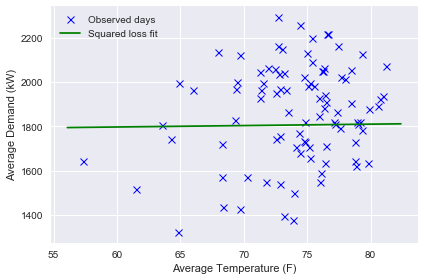

In [21]:
#============================================================
# Visualizing data with linear regression
#============================================================
plt.plot(X_test, y_test, 'bx')
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
plt.plot(xlim, [theta[0]*xlim[0]+theta[1], theta[0]*xlim[1]+theta[1]], 'g-')
plt.ylim(ylim)
plt.legend(["Observed days", "Squared loss fit"], loc="upper left")
plt.xlabel("Average Temperature (F)")
plt.ylabel("Average Demand (kW)")
plt.tight_layout()

### 2. Naive Bayes (30 points)

In this question we are going to use Naive Bayes to predict the amount bikers given some features about the season, weather and the hour of the day. Specifically the features are as follow:

- **season**: can take 4 values $\in \{1,2,3,4\}$


- **hour**: representing hour of the day. The data here is already been categorized into four categories:
    - cateogory 1: hour $\in \{0,1,2,3,4,5\}$
    - cateogory 2: hour $\in \{6,7,8,9,10,11\}$
    - cateogory 3: hour $\in \{12,13,14,15,16,17\}$
    - cateogory 4: hour $\in \{18,19,20,21,22,23\}$
    
    
- **workingday**: is 0 if it is a holiday and 1 if it is a working day.


- **weather**: representing the weather. The data here is already been categorized into three categories:
    - cateogory 1: clear, few clouds, partly cloudy
    - cateogory 2: mist, cloudy
    - cateogory 3: light snow, thunderstorm
  
  
- **temp**: representing the temperature that is categorized in five categories:
    - cateogory 1: temp $\in [0,0.2]$
    - cateogory 2: temp $\in (0.2,0.4]$
    - cateogory 3: temp $\in (0.4,0.6]$
    - cateogory 4: temp $\in (0.6,0.8]$
    - cateogory 5: temp $\in (0.8,1]$   
 
 
- **hum**: representing the humidity that is categorized in five categories:
    - cateogory 1: hum $\in [0,0.2]$
    - cateogory 2: hum $\in (0.2,0.4]$
    - cateogory 3: hum $\in (0.4,0.6]$
    - cateogory 4: hum $\in (0.6,0.8]$
    - cateogory 5: hum $\in (0.8,1]$
 
 
- **windspeed**: representing the wind speed that is categorized in five categories:
    - cateogory 1: windspeed $\in [0,0.2]$
    - cateogory 2: windspeed $\in (0.2,0.4]$
    - cateogory 3: windspeed $\in (0.4,0.6]$
    - cateogory 4: windspeed $\in (0.6,0.8]$
    - cateogory 5: windspeed $\in (0.8,1]$


- **Class label**: the class labels are number of bikers which are categorized as follow:
    - cateogory 1: count $\in [0,100]$
    - cateogory 2: count $\in [101,200]$
    - cateogory 3: count $\in [201,300]$
    - cateogory 4: count $\in [301,400]$
    - cateogory 5: count $\in [401,500]$
    - cateogory 6: count $\in [501,600]$
    - cateogory 7: count $\in [601,700]$

**Part 1. (10 points)** You are given two datasets, bike_train.csv and bike_test.csv. First learn a Naive Bayes classifier basad on the training data and calculate the training accuracy. 


In [22]:
from datascience import *
import numpy as np
# Your analysis and answers here:
table_train = Table.read_table('bike_train.csv')
table_test = Table.read_table('bike_test.csv')
table_test = table_test.where(0, are.between_or_equal_to(0,7)) #Only legitimate inputs

#Make a table for each count type and calculate how many values are in each table
table_1 = table_train.where('count',1) #All the data points in training data where count == 1
num_1 = table_1.num_rows
table_2 = table_train.where('count',2) #All the data points in training data where count == 2
num_2 = table_2.num_rows
table_3 = table_train.where('count',3) #All the data points in training data where count == 3
num_3 = table_3.num_rows
table_4 = table_train.where('count',4) #All the data points in training data where count == 4
num_4 = table_4.num_rows
table_5 = table_train.where('count',5) #All the data points in training data where count == 5
num_5 = table_5.num_rows
table_6 = table_train.where('count',6) #All the data points in training data where count == 6
num_6 = table_6.num_rows
table_7 = table_train.where('count',7) #All the data points in training data where count == 7
num_7 = table_7.num_rows

#Calculate Prior probability
#Recall prior = # of elements of that type in the set / total elements
Y = [(num_1 / table_train.num_rows)]
Y.append((num_2 / table_train.num_rows))
Y.append((num_3 / table_train.num_rows))
Y.append((num_4 / table_train.num_rows))
Y.append((num_5 / table_train.num_rows))
Y.append((num_6 / table_train.num_rows))
Y.append((num_7 / table_train.num_rows))


#Make a matrix for every field 
#We will be inserting the posterior probabilities into these matricies
X_season = np.zeros((4,7))
X_hour = np.zeros((4,7))
X_workingday = np.zeros((2,7))
X_weather = np.zeros((3,7))
X_temp = np.zeros((5,7))
X_hum = np.zeros((5,7))
X_windspeed = np.zeros((5,7))


#Calculating posterior probabilities, where row r and column c correspond to P(r|c) 
#Each row will correspond with the possible values a field can take on 
#Each column will correspond with the possible values for count  
    #Ex. The second row and third column of X_season contains the probability that season=2 when count is 3
    
for i in range(0,7):
    for j in range(0,4):
        X_season[j,i] = table_train.where('season', j+1).where('count', i+1).num_rows  / (table_train.where('count', i+1).num_rows)
        X_hour[j,i] = table_train.where('hour',j+1).where('count',i+1).num_rows  / (table_train.where('count',i+1).num_rows)
    for k in range(0,2):
        X_workingday[k,i] = table_train.where('workingday',k).where('count',i+1).num_rows  / (table_train.where('count',i+1).num_rows)
    for l in range(0,3):    
        X_weather[l,i] = table_train.where('weather',l+1).where('count',i+1).num_rows  / (table_train.where('count',i+1).num_rows)
    for m in range(0,5):    
        X_temp[m,i] = table_train.where('temp',m+1).where('count',i+1).num_rows  / (table_train.where('count',i+1).num_rows)
        X_hum[m,i] = table_train.where('hum',m+1).where('count',i+1).num_rows  / (table_train.where('count',i+1).num_rows)
        X_windspeed[m,i] = table_train.where('windspeed',m+1).where('count',i+1).num_rows  / (table_train.where('count',i+1).num_rows)
    

    
    
#Create a matrix with the given data 
X_train = np.empty((table_train.num_rows,7))

X_train[:,0] = table_train.select('season')[0] #First column for seasons
X_train[:,1] = table_train.select('hour')[0] #Second column for seasons
X_train[:,2] = table_train.select('workingday')[0] #Third column for seasons
X_train[:,3] = table_train.select('weather')[0] #Fourth column for seasons
X_train[:,4] = table_train.select('temp')[0] #Fifth column for seasons
X_train[:,5] = table_train.select('hum')[0] #Sixth column for seasons
X_train[:,6] = table_train.select('windspeed')[0] #Seventh column for seasons


#Create a matrix for all the probabilities of each data point
#For each input of the data, we will input the probability of each of the seven choices (count==1, count==2,...) into a row
#The possibility with the greatest probability will be our guess
    #Ex. the third row and fourth column corresponds to the probability that the third data point is count 4
Y_train = np.zeros((len(X_train), 7))



#Now fill the probability for every data point for every possible count value that point can take on

for i in range(0, len(X_train)):
    z = X_train[i,:].astype(np.int) #Given fields for a data point, z
    V_season = X_season[(z[0]-1),:] #Find the probability for each count possibility given z's season value
    V_hour = X_hour[(z[1]-1),:]     #Find the probability for each count possibility given z's hour value
    V_workingday = X_workingday[(z[2]),:] #Find the probability for each count possibility given z's workingday value
    V_weather = X_weather[(z[3]-1),:] #Find the probability for each count possibility given z's weather value
    V_temp = X_temp[(z[4]-1),:]     #Find the probability for each count possibility given z's temp value
    V_hum = X_hum[(z[5]-1),:]       #Find the probability for each count possibility given z's hum value
    V_windspeed = X_windspeed[(z[6]-1),:] #Find the probability for each count possibility given z's windspeed value
    Y_train[i,:] = V_season * V_hour*V_workingday*V_weather*V_temp*V_hum*V_windspeed*Y #Remeber NAIVE bayes (all independent)
    Y_train[i,:] = Y_train[i,:] / sum(Y_train[i,:]) #Optional: Smooth the values by their porportion of each other so that their sum equals 1 
    

    
    
    
#Now that we have the desired probabilites, for each data point pick the index with the highest probability to be our guess
Labels = np.argmax(Y_train,axis = 1) + 1 #Remember that indexing starts at 0, so the nth element corresponds to the count = n+1      


#Now lets attach our guess onto the data
train_with_guess = table_train.with_column("guess", Labels)
train_with_guess


#Now lets check how we did!
accuracy = sum(train_with_guess.column('count') == train_with_guess.column('guess')) / train_with_guess.num_rows 
accuracy

0.59916666666666663

**Part 2. (10 points)** Then, apply your trained model to the testing dataset and predict the number of bikers and calculate the testing accuracy in prediction. What can you say about comparison among the training and testing accuracy? 


In [23]:
#Create a matrix with the new data 
X_test = np.empty((table_test.num_rows,7))

X_test[:,0] = table_test.select('season')[0] #First column for seasons
X_test[:,1] = table_test.select('hour')[0] #Second column for seasons
X_test[:,2] = table_test.select('workingday')[0] #Third column for seasons
X_test[:,3] = table_test.select('weather')[0] #Fourth column for seasons
X_test[:,4] = table_test.select('temp')[0] #Fifth column for seasons
X_test[:,5] = table_test.select('hum')[0] #Sixth column for seasons
X_test[:,6] = table_test.select('windspeed')[0] #Seventh column for seasons

#Create a matrix for all the probabilities of each data point
#For each input of the data, we will input the probability of each of the seven choices (count==1, count==2,...) into a row
#The possibility with the greatest probability will be our guess
    #Ex. second row third column is probability that the second datapoint count==3
Y_test = np.zeros((len(X_test), 7))




#Now fill the probability for every data point for every possible count value that point can take on
#Note we are still using X_Season, X_hour, ... etc from part 1, this is because we are using the data from part 1 to give predictions about the data in part 2   

for i in range(0, len(X_test)):
    z = X_test[i,:].astype(np.int) #Given fields for a data point, z
    V_season = X_season[(z[0]-1),:] #Find the probability for each count possibility given z's season value
    V_hour = X_hour[(z[1]-1),:]     #Find the probability for each count possibility given z's hour value
    V_workingday = X_workingday[(z[2]),:] #Find the probability for each count possibility given z's workingday value
    V_weather = X_weather[(z[3]-1),:] #Find the probability for each count possibility given z's weather value
    V_temp = X_temp[(z[4]-1),:]     #Find the probability for each count possibility given z's temp value
    V_hum = X_hum[(z[5]-1),:]       #Find the probability for each count possibility given z's hum value
    V_windspeed = X_windspeed[(z[6]-1),:] #Find the probability for each count possibility given z's windspeed value
    Y_test[i,:] = V_season * V_hour*V_workingday*V_weather*V_temp*V_hum*V_windspeed*Y #Remeber NAIVE bayes (all independent)
    Y_test[i,:] = Y_test[i,:] / sum(Y_test[i,:]) #Optional: Smooth the values by their porportion of each other so that their sum equals 1 
    

    
    
#Now that we have the desired probabilites, for each data point pick the index with the highest probability to be our guess
Labels = np.argmax(Y_test,axis = 1) + 1 #Remember that indexing starts at 0, so the nth element corresponds to the count = n+1      




#Now lets attach our guess onto the data
test_with_guess = table_test.with_column("guess", Labels)


#Now lets check how we did!
accuracy = sum(test_with_guess.column('count') == test_with_guess.column('guess')) / test_with_guess.num_rows 
accuracy

0.62015222906850309

**Part 3. (10 points)** What if you only use two features of season and and workingday for predicting the number of bikers for the testing data? How testing accuracy is different with respect to trainig accuracy? 

In [24]:
#Now fill the probability for every data point for every possible count value that point can take on
#Note we are still using X_Season, X_hour, ... etc from part 1, this is because we are using the data from part 1 to give predictions about the data in part 2 
#Note we are only using seasons and workingday

for i in range(0, len(X_test)):
    z = X_test[i,:].astype(np.int) #Given fields for a data point, z
    V_season = X_season[(z[0]-1),:] #Find the probability for each count possibility given z's season value
    V_workingday = X_workingday[(z[2]),:] #Find the probability for each count possibility given z's workingday value
    Y_test[i,:] = V_season * V_workingday * Y #Remeber NAIVE bayes (all independent)
    Y_test[i,:] = Y_test[i,:] / sum(Y_test[i,:]) #Optional: Smooth the values by their porportion of each other so that their sum equals 1 
    

    
#Now that we have the desired probabilites, for each data point pick the index with the highest probability to be our guess
Labels = np.argmax(Y_test,axis = 1) + 1 #Remember that indexing starts at 0, so the nth element corresponds to the count = n+1      



#Now lets attach our guess onto the data
test_with_season_workingday = table_test.with_column("guess", Labels)


#Now lets check how we did!
accuracy = sum(test_with_season_workingday.column('count') == test_with_season_workingday.column('guess')) / test_with_season_workingday.num_rows 
accuracy

0.48568321855744834

### 3. Bayesian networks (40 points)

This question will refer to the graphical model shown below, which encode a set of independencies among the following variables: Season (S), Flu (F), Dehydration (D), Chills (C), Headache (H), Nausea (N), and Dizziness (Z).

<img src="flu.png", width="500">

**Part 1: Independencies in Bayesian networks (12 points)** 

Consider the model shown above. Indicate whether the following independence statements are true or false according to this model. Provide a very brief justification of your answer (think of active trails and d-separation).

1- Season $\perp$ Chills


2- Season $\perp$ Chills $\mid$ Flu


3- Season $\perp$ Headache $\mid$ Flu


4- Season $\perp$ Headache $\mid$ Flu, Dehydration


5- Season $\perp$ Nausea $\mid$ Dehydration


6- Season $\perp$ Nausea $\mid$ Dehydration, Headache


7- Flu $\perp$ Dehydration


8- Flu $\perp$ Dehydration $\mid$ Season, Headache


9- Flu $\perp$ Dehydration $\mid$ Season


10- Flu $\perp$ Dehydration $\mid$ Season, Nausea


11- Chills $\perp$ Nausea 


12- Chills $\perp$ Nausea $\mid$ Headache



**Part 2: Factorized joint distributions (3 points)** 

1- Using the Bayesian network shown above write down the factorized form of the joint distribution over all of the variables, $p(S,F,D,C,H,N,Z)$


**Part 3: Evaluating probability queries (25 points)**

Assume you are given the conditional probability tables listed below for the model shown in the first figure. Evaluate each of the probabilities queries listed below and show your calculations.

<img src="flu2.png", width="500">


1- What is the probability that you have the flu, when no prior information is known?


2- What is the probability that you have the flu, given that it is winter?


3- What is the probability that you have the flu, given that it is winter and that you have a headache?


4- What is the probability that you have the flu, given that it is winter, you have a headache, and you know that you are dehydrated?


5- Does knowing your are dehydrated increase or decrease your likelihood of having the flu? Intuitively, does this make sense?

In [ ]:
# Your analysis and answers here:# Your analysis and answers here:

### Bonus Question: (20 points) 

Let $H_i$ be a random variable taking on values $l$ and $r$ that denotes the handedness of some individual $i$. A simple hypothesis for handedness is that it is inherited in the following way:

- there is a single gene $G_i$ that effects $H_i$,


- $H_i = G_i$ with probability $p > 0.5$,


- the gene is inherited from a single parent, and it is equally likely to be inherited from either,


- there is a small non-zero probability $m$ that the gene mutates after inheritance (e.g. if the child inherits from the father and $G_{father} = r$, then with probability $m$, $G_{child} = l$).


(a) (10 points) Draw a Bayes' network with nodes $G_i$ and $H_i$ for $i \in \{child, mother, father\}$ that shows this hypothesis.


(b) (4 points) Answer the following using d-separation argument.

- is $H_{mother}$ independent of $H_{father}$?


- is $H_{mother}$ independent of $H_{father}$ given $H_{child}$?


- is $H_{child}$ independent of $G_{mother}$ given $G_{child}$?


- is $H_{child}$ independent of $G_{mother}$ given $H_{mother}$?


(c) (2 points) Give the conditional probability table for $G_{child}$.



(d) (2 points) Suppose $p(G_{father} = l) = p(G_{mother} = l) = x$. Derive an expression for $p(G_{child} = l)$ in terms of $x$ and $m$ by conditioning on the parent nodes. 


(e) (2 points) Suppose genetic equilibrium holds, i.e. that the distribution of genes in every generation is the same. Calculate $x$. Do you think the hypothesis for handedness described in this question holds? Explain.


In [ ]:
# Your analysis and answers here:

# Load OKpy

In [ ]:
from client.api.notebook import Notebook
ok = Notebook('HW2.ok')
_ = ok.auth(inline=True)

# Submit to OKpy

In [ ]:
_ = ok.submit()